# Построение моделей решающих дерьевьев и ансамблей.

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import json
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from scipy.stats import randint, uniform
from search_hyperparameters import search_hyperparameters
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, auc

## Классификация (бинарная True\False)

### Загрузка датасета

In [2]:
data_classifier = pd.read_csv('csgo_filtred.csv')

X_cl = data_classifier.drop(columns=['bomb_planted'], axis=1)
y_cl = data_classifier['bomb_planted']

<Axes: ylabel='bomb_planted'>

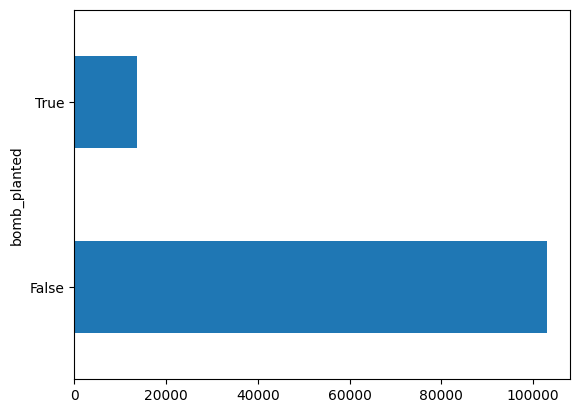

In [3]:
y_cl.value_counts().plot.barh()

In [4]:
y_cl.value_counts()

bomb_planted
False    102945
True      13684
Name: count, dtype: int64

In [5]:
X_cl['map'].value_counts()

map
de_inferno     22806
de_dust2       21040
de_nuke        17879
de_mirage      17641
de_overpass    13375
de_train       12800
de_vertigo     10733
unknown          211
de_cache         144
Name: count, dtype: int64

In [6]:
X_cl['map'] = X_cl['map'].str.strip().str.lower()
mapping = {
    'de_inferno': 1,
    'de_dust2': 2,
    'de_nuke': 3,
    'de_mirage': 4,
    'de_overpass': 5,
    'de_train': 6,
    'de_vertigo': 7,
    'unknown': 8,
    'de_cache': 9
}

X_cl['map'] = X_cl['map'].map(mapping)
X_cl['map'].value_counts()

map
1    22806
2    21040
3    17879
4    17641
5    13375
6    12800
7    10733
8      211
9      144
Name: count, dtype: int64

### Разделение на тренировочную и тестовую выборки

In [7]:
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, stratify=y_cl, train_size=0.8, test_size=0.2)
X_test_cl.shape, X_train_cl.shape

((23326, 20), (93303, 20))

In [8]:
X_train_cl_search, X_test_cl_search, y_train_cl_search, y_test_cl_search = train_test_split(X_cl, y_cl, stratify=y_cl, train_size=0.1, test_size=0.01)
X_test_cl_search.shape, X_train_cl_search.shape

((1167, 20), (11662, 20))

In [9]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Т.к. классы несбалансированы, был построен пайплайн включаюший в себя маштабирование выборок и её балансировка при помощи SMOTEENN.

In [10]:
def build_pipeline(model):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('sampler', SMOTEENN(sampling_strategy=1, random_state=42)),
        ('model', model)
    ])
    return pipe

In [11]:
def metrics(pred_array, true_array):
    print(f'F1: {f1_score(true_array, pred_array)}')
    print(f'accuracy: {accuracy_score(true_array, pred_array)}')
    print(f'precision: {precision_score(true_array, pred_array)}')
    print(f'recall: {recall_score(true_array, pred_array)}')
    print(f'roc_auc_score: {roc_auc_score(true_array, pred_array)}')

In [12]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores.*loky.backend.context"
)

In [13]:
y_test_cl.shape

(23326,)

### DesicionTreeRegressor

In [25]:
models = ['DecisionTreeClassifier']
methods = ['GridSearchCV', 'RandomizedSearchCV']

In [34]:
parameters = {
    'DecisionTreeClassifier': {
        'GridSearchCV': {
            'criterion':          ['gini', 'entropy'],
            'max_depth':          [5, 10, None],
            'min_samples_leaf':   [1, 5, 10],
            'class_weight':       [None, 'balanced']
        },
        'RandomizedSearchCV': {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'splitter': ['best', 'random'],
            'max_depth': randint(3, 30),
            'min_samples_split': randint(2, 50),
            'min_samples_leaf': randint(1, 20),
            'max_features': [None, 'sqrt', 'log2', 0.3, 0.5, 0.7],
            'max_leaf_nodes': randint(10, 100),
            'ccp_alpha': uniform(0.0, 0.02),
            'class_weight': [None, 'balanced', {0: 1, 1: 3}, {0: 1, 1: 5}]
        }
    }
}

In [35]:
best_params = {}

for model in models:
    best_params[model] = {}
    for method in methods:
        print(f'Сейчас на {model}, {method}')
        searcher = search_hyperparameters(
            model_name=model,
            method_search=method,
            X_train=X_train_cl,
            y_train=y_train_cl,
            param_grid=parameters[model][method],
            n_jobs=-1,
            cv=3,
            scoring='f1'
        )
        best_params[model][method] = {
            'params': searcher['best_params'],
            'score': searcher['best_score']
        }

Сейчас на DecisionTreeClassifier, GridSearchCV
Сейчас на DecisionTreeClassifier, RandomizedSearchCV


In [36]:
def convert(o):
    if isinstance(o, np.generic):
        return o.item()
    raise TypeError

with open('best_params.json', 'w') as f:
    json.dump(best_params, f, indent=4, default=convert)

In [ ]:
dt_classifier = build_pipeline(DecisionTreeClassifier(
    max_depth=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['max_depth'],
    class_weight=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['class_weight'],
    criterion=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['criterion'],
    min_samples_leaf=best_params['DecisionTreeClassifier']['GridSearchCV']['params']['min_samples_leaf'],
))

# Hold-out
dt_classifier.fit(X_train_cl, y_train_cl)
y_pred_cl_dt = dt_classifier.predict(X_test_cl)
metrics(pred_array=y_pred_cl_dt, true_array=y_test_cl)

# K-fold
k_fold_cl_dt = cross_validate(dt_classifier, X_train_cl, y_train_cl, cv=kf, scoring='f1')
df_k_fold_cs_dt = pd.DataFrame(k_fold_cl_dt)
df_k_fold_cs_dt

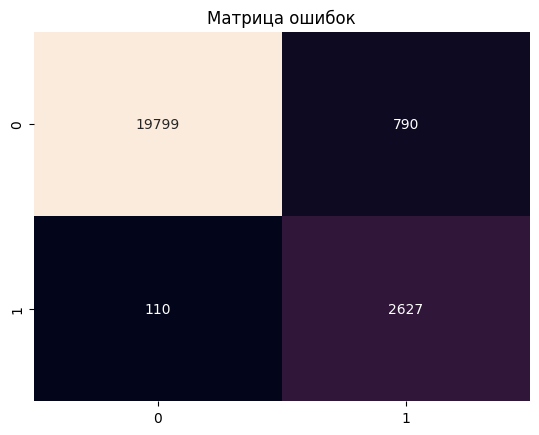

In [ ]:
cm_dt_cl = confusion_matrix(y_test_cl, y_pred_cl_dt)

plt.figure()
sns.heatmap(cm_dt_cl, annot=True, fmt='d', cbar=False)
plt.title('Матрица ошибок')
plt.show()

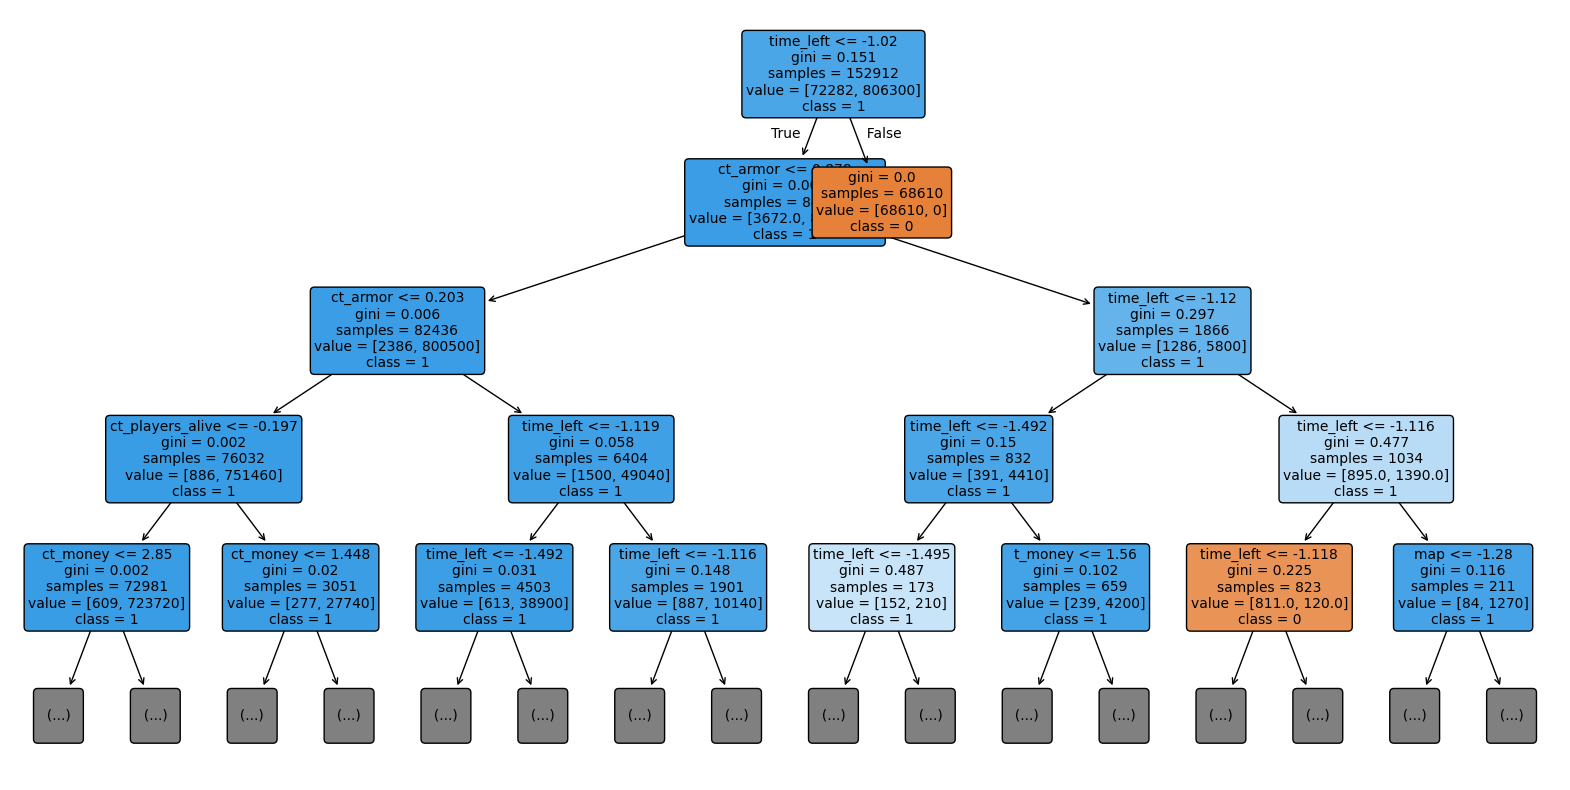

In [ ]:
plt.figure(figsize=(20, 10))
tree.plot_tree(
    dt_classifier.named_steps['model'],
    feature_names=X_cl.columns.to_list(),
    class_names=['0','1'],
    filled=True,
    rounded=True,
    max_depth=4,
    fontsize=10
)
plt.show()